In [1]:
import os, warnings
#warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy.core.defchararray import rpartition
import seaborn as sns
import pandas as pd
#from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import numpy as np
from copy import deepcopy
import datetime
#pd.set_option('display.max_rows', 10**5)
pd.set_option('display.max_columns', 10**5)

from importlib import reload
import adtk
import pweave     # for markdown reports


/home/jovyan/.conda/envs/env_tsanomaly/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from aac_ts_anomaly.utils import tsa_utils as tsa
#from aac_ts_anomaly.utils import utils_func as util
from aac_ts_anomaly.config import global_config as glob
from aac_ts_anomaly.services import file

reload(tsa)
reload(file)
reload(glob)

glob.UC_CODE_DIR

Environment Variable: UC_CODE_DIR has been set to default: /home/jovyan/aac_anomaly_detection/src
Environment Variable: UC_DATA_DIR has been set to default: /home/jovyan/data
Environment Variable: UC_PORT has been set to default: 5000
Environment Variable: UC_APP_CONNECTION has been set to default: 127.0.0.1


'/home/jovyan/aac_anomaly_detection/src'

In [3]:
from aac_ts_anomaly.resources import config

reload(config)


<module 'aac_ts_anomaly.resources.config' from '/home/jovyan/aac_anomaly_detection/src/aac_ts_anomaly/resources/config.py'>

In [4]:
anomaly_history = pd.DataFrame(columns=['time_anomaly', 'time_series_name', 'clm_cnt'])
anomaly_history

# Use pickle file as substitute for Postgres:
pkl = file.PickleService(path = "anomaly_history.pkl")

pkl.doWrite(anomaly_history)

pkl.doRead()

,time_anomaly,time_series_name,clm_cnt


In [81]:
# filename = util.get_newest_file(search_for = "AGCS CCO CRA - Monthly Incurred amounts",  src_dir=glob.UC_DATA_DIR)
# xls = file.XLSXService(path=filename, root_path=glob.UC_DATA_DIR, dtype= {'time': str}, sheetname='data', index_col=None, header=0)
# filename

# data_orig = xls.doRead()

# data_orig.shape

# data_orig.head()

In [82]:
#pg = file.PostgresService(verbose=False)

#data_orig = pg.doRead(qry = 'select * from "Incurred_Expected_CAYPAY"')   
#data_orig.shape
#data_orig.head()

import pandas as pd
import numpy as np
from copy import deepcopy
import glob as gl
import subprocess, os
from datetime import datetime, date
import dateutil.parser as dateparser

from dateutil.relativedelta import relativedelta

from textdistance import jaro_winkler
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, QuantileAD
from adtk.detector import LevelShiftAD, VolatilityShiftAD, SeasonalAD, AutoregressionAD
from adtk.transformer import DoubleRollingAggregate, RollingAggregate, Retrospect, ClassicSeasonalDecomposition
from adtk.pipe import Pipeline, Pipenet
from adtk.aggregator import AndAggregator, OrAggregator
from adtk.data import split_train_test
from importlib import reload
from claims_reporting.config import global_config as glob
from claims_reporting.resources import config
from claims_reporting.services import file


ts_col='target'
periodicity = 12

target_col = ts_col  #ts_col: column name of target time series in df
#periodicity = periodicity    # 12 or 52 : seasonal period in the data. Currently: monthly, weekly (i.e. calendar weeks)

reload(config)

# Get parameters from I/O yaml
if periodicity == 12 : 
    config_input = config.in_out12['input']
    config_output = config.in_out12['output']
    config_detect = config.in_out12['detection']

if periodicity == 52 : 
    config_input = config.in_out52['input']
    config_output = config.in_out52['output']
    config_detect = config.in_out52['detection']
#------------------------------------------------------------------

hyper_para = config_detect['training']['hyper_para']
transformers = config_detect['training']['transformers']
stat_transform = config_detect['training']['stat_transform']
outlier_filter = config_detect['training']['outlier_filter']
aggreg_level, pre_filter, ignore_lag, min_sample_size, min_median_cnts = list(config_detect['preprocessing'].values())
tbl_name = config_output['database']['tbl_name']
detect_thresh = config_detect['prediction']['detect_thresh']


if outlier_filter is None:
        six_months_ago = date.today() - relativedelta(months=+6)
        outlier_filter = six_months_ago.strftime("%Y-%m")
        print('Detect anomalies not older than {}.'.format(outlier_filter))


# model_transf = list(transformers.keys())[0]
# model_transf

# from adtk.detector import OutlierDetector
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.ensemble import IsolationForest

# reload(config)

# for z, model in enumerate(hyper_para.keys()): 
#         print(z, model)

# model+"("+"**hyper_para['"+model+"'])"
# model
# hyper_para['OutlierDetector']

# anom_detector = eval(model+"("+"**hyper_para['"+model+"'])")               # evaluate estimator expressions
# model_abstr = [(model, anom_detector)]
# pipe = Pipeline(model_abstr)
#train_res = pipe.fit_detect(self.s_deseasonal).rename(model, inplace=False).to_frame()     # fit estimator and predict


def _convert2date(y, t):
        return datetime.strptime(f'{y} {t} 1', '%Y %m %d')  # %G, %V, %u are ISO equivalents of %Y, %W, %w

def _year_week(y, w):
        return datetime.strptime(f'{y} {w} 1', '%G %V %u')  # %G, %V, %u are ISO equivalents of %Y, %W, %w

def _correct_cweek_53(dat : pd.core.frame.DataFrame, time_col : str = 'year_period_ts', target_col : str = 'clm_cnt', verbose=False):
        """
        This aggregates non-unique dates which were generated by 
        transforming from calendar week to a representative day 
        of that week (using _year_week function)
        Example: 
        2019-53 : 2019-12-30 and 2020-01: 2019-12-30. 
        These two will be summed up to have unique date points 
        for time series analysis. Result will remove 2019-53 for example
        """
        my_ts = deepcopy(dat)
        ssa = my_ts.groupby([time_col]) 
        #time_duplicates = ssa.agg(size=(target_col,'count')).reset_index()
        deduplicated_ts = ssa.agg(target = (target_col,'sum')).reset_index()
        my_ts.drop(columns=[target_col], inplace = True)
        my_ts_new = my_ts.merge(deduplicated_ts, how='left', left_on=[time_col], right_on=[time_col])
        my_ts_new.drop_duplicates(subset=[time_col, target_col], keep='last', inplace=True)
        my_ts_new.reset_index(inplace=True)
        if verbose:
            print('{} rows aggregated'.format(my_ts.shape[0]-my_ts_new.shape[0]))
        return my_ts_new

def q_50(x):
    return x.quantile(0.5)

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

#########################################################################################
############################### START
######################################################################################

aggreg_level = 'all_combi'
ignore_lag = 1 
min_sample_size = 20
min_median_target = None 
verbose = True
aggreg_dimensions = ['Region', 'OE', 'Lob',  'LossCat']


# Overwrite I/O yaml spec. if user arguments are given:
#--------------------------------------------------------
if ignore_lag is not None:
    ignore_lag = ignore_lag
if min_sample_size is not None:    
    min_sample_size = min_sample_size
if min_median_target is not None:
    min_median_target = min_median_target    
if aggreg_level is not None:
    aggreg_level = aggreg_level   
if verbose:
    print('Periodicity: {}'.format(periodicity)) 
    print("Aggregation type: '{}'".format(aggreg_level)) 
print('Parameters: ignore_lag {}, min_sample_size {}, min_median_target {}'.format(ignore_lag, min_sample_size, min_median_target)) 

df0 = deepcopy(data_orig)
df0.rename(columns={'Line of Business': 'Lob', 'Source System': 'source_sys', 'Sub Line of Business': 'SubLob', 'Loss Category': 'LossCat'}, inplace=True)

df0.columns

# Apply a prefiltering step, 
# most often to filter out Brazil, South America data
if pre_filter is not None:
    try:
        df0 = df0.query(pre_filter)
        if verbose: print('pre-filter applied.')
    except Exception as e:
        if verbose: print(pre_filter,e)  

df = deepcopy(df0)
print(df.shape)
#df.dropna(inplace=True)
print(df.shape)

years = df['time'].apply(lambda x: x[:4]).astype(int)
periods = df['time'].apply(lambda x: x[5:]).astype(int)


max_year = max(years)
min_year = min(years)
max_years = (years == max_year)
min_years = (years == min_year)
max_period = max(periods[max_years])
min_period = min(periods[min_years])

thresh_period = max_period - ignore_lag
thresh_year = max_year

min_year_period = str(int(min_year))+'-'+'{0:02d}'.format(int(min_period))
max_year_period = str(int(max_year))+'-'+'{0:02d}'.format(int(max_period))
#min_calendar_week = str(int(min_year))+'-'+'{0:02d}'.format(int(min_week))
#max_calendar_week = str(int(max_year))+'-'+'{0:02d}'.format(int(max_week))
if verbose:
    print("Ignoring claims younger than:",str(int(thresh_year))+'-'+'{0:02d} in detection'.format(int(thresh_period)))

time_filter = ~((periods > thresh_period) & (years == thresh_year))
#df_orig = deepcopy(df)

# Apply time filter to prefiltered data:
df = df[time_filter]
periods, years = periods[time_filter], years[time_filter]
period_seq = np.arange(min(periods), max(periods)+1)
year_seq = np.arange(min(years), max(years)+1)

Detect anomalies not older than 2021-03.
Periodicity: 12
Aggregation type: 'all_combi'
Parameters: ignore_lag 1, min_sample_size 20, min_median_target None
pre-filter applied.
(1199963, 9)
(1199963, 9)
Ignoring claims younger than: 2021-08 in detection


In [83]:
# For multivariate time series creation below:
#----------------------------------------------
time_index = []
for y in year_seq:
        for p in period_seq:
            time_index.append(str(int(y))+'-'+'{0:02d}'.format(int(p)))  # calendar weeks
#max_cweek_index = np.where(max_calendar_week == np.array(time_index))[0][0]
max_period_index = np.where(max_year_period == np.array(time_index))[0][0]

df.columns

Index(['Lob', 'OE', 'source_sys', 'LossCat', 'Region', 'clm_no', 'time',
       'target', 'year'],
      dtype='object')

In [84]:
agg_func = 'sum'           # must be one of numpy's functions, e.g. np.mean()


# Deduplicate:
#---------------
gr = df.groupby(['Region', 'OE', 'Lob', 'LossCat']) 
#gr0 = df.groupby(aggreg_dimensions + ['time'])
#gr0 = df.groupby(['Region', 'OE', 'Lob', 'SubLob', 'LossCat'] + ['time'])
gr0 = df.groupby(['Region', 'OE', 'Lob', 'LossCat'] + ['time', 'target'])

df.head()
target_col
#gr0.agg(target = (target_col, agg_func))
#gr0.agg(size=('clm_no', 'count'))#.reset_index()
ts = gr0.agg(size=('clm_no', 'count')).reset_index()

In [85]:
df[['Region', 'OE', 'Lob', 'LossCat'] + ['time', 'target']].head()

,Region,OE,Lob,LossCat,time,target
0,North America,US,Financial Lines,1-Attritional,2021-04,251121.0
1,North America,US,Financial Lines,1-Attritional,2021-04,25000.0
2,North America,US,Financial Lines,1-Attritional,2020-06,0.0
3,North America,US,Financial Lines,1-Attritional,2021-04,0.0
4,North America,US,Financial Lines,1-Attritional,2020-06,50000.0


In [87]:
ts = df[(df.Region == 'North America') & (df.OE == 'US') & (df.Lob == 'Financial Lines') & (df.LossCat == '1-Attritional') & (df.year == 2015.0)].sort_values(by = ['time'])
ts

,Lob,OE,source_sys,LossCat,Region,clm_no,time,target,year
389318,Financial Lines,US,Cognos,1-Attritional,North America,00515176566,2015-01,0.000000,2015.0
292325,Financial Lines,US,Cognos,1-Attritional,North America,00515184084,2015-01,0.000000,2015.0
815996,Financial Lines,US,Cognos,1-Attritional,North America,00515176677,2015-01,0.000000,2015.0
435574,Financial Lines,US,Cognos,1-Attritional,North America,17315042695,2015-01,0.000000,2015.0
435573,Financial Lines,US,Cognos,1-Attritional,North America,17315042634,2015-01,145.610001,2015.0
...,...,...,...,...,...,...,...,...,...
306626,Financial Lines,US,Cognos,1-Attritional,North America,00515230927,2015-12,0.000000,2015.0
674470,Financial Lines,US,Cognos,1-Attritional,North America,00515233714,2015-12,0.000000,2015.0
674458,Financial Lines,US,Cognos,1-Attritional,North America,00515233273,2015-12,65148.949219,2015.0
595443,Financial Lines,US,Cognos,1-Attritional,North America,00515233367,2015-12,0.000000,2015.0


In [88]:
#ts = gr0.get_group(("Asia Pacific", "Australia", "Aviation", "1-Attritional", '2015-01'))

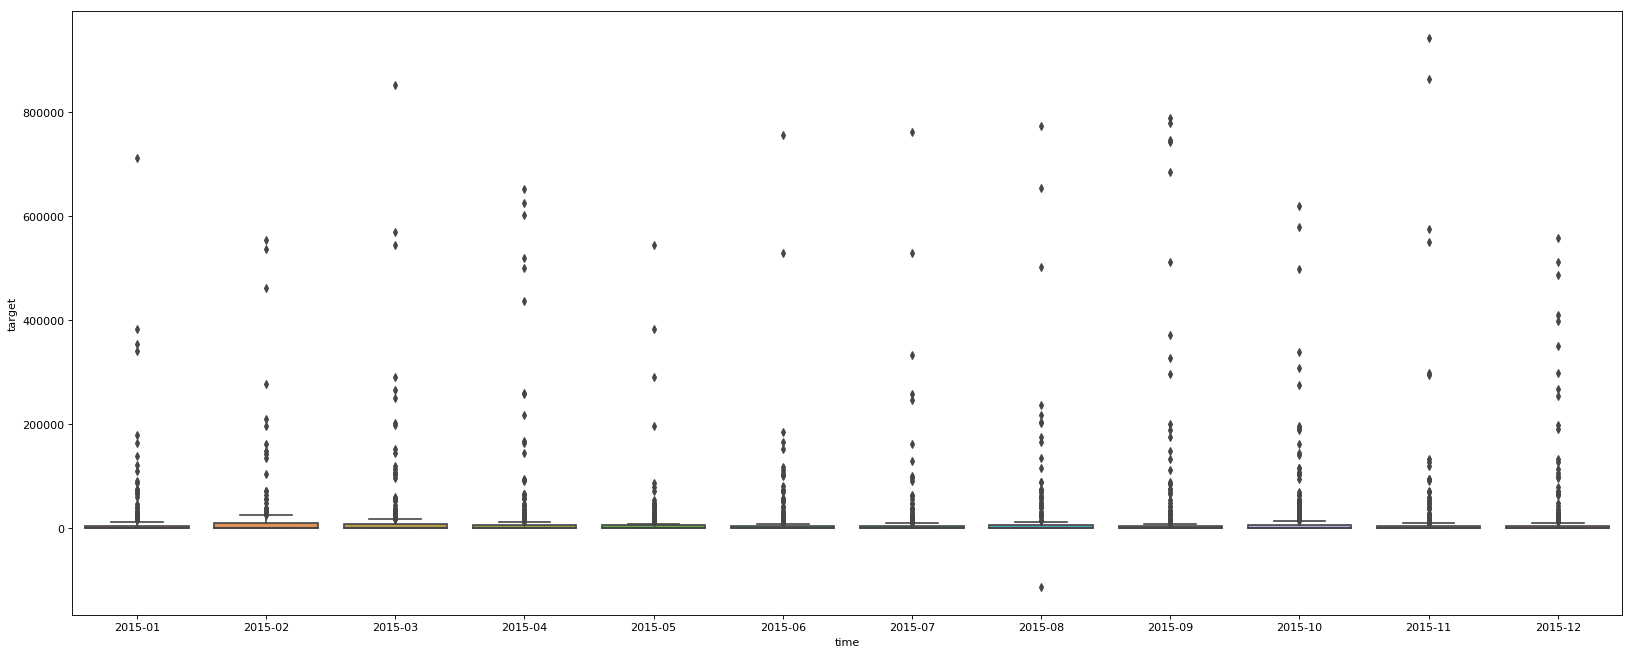

In [89]:
fig, axes = plt.subplots(figsize=(25,10), dpi= 80)
seaborn.boxplot(x='time', y='target', data=ts, ax=axes)#.set(xlabel='years', ylabel="EUR")

In [46]:
gr.get_group(("Asia Pacific", "Australia", "Aviation", "1-Attritional")).sort_values(by=['time'])

,Lob,OE,source_sys,LossCat,Region,clm_no,time,target
201207,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990009880,2015-01,14229.0
194176,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990009770,2015-01,14407.0
231722,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990009775,2015-01,19239.0
200951,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990009815,2015-01,67873.0
217566,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990009817,2015-01,6331.0
...,...,...,...,...,...,...,...,...
195697,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990018661,2020-05,38682.0
201817,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990018746,2020-06,97164.0
201861,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990019461,2020-08,374785.0
201842,Aviation,Australia,Regent-Australia,1-Attritional,Asia Pacific,C1990019228,2020-11,28320.0


/home/G126143/anaconda3/envs/env_finance/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


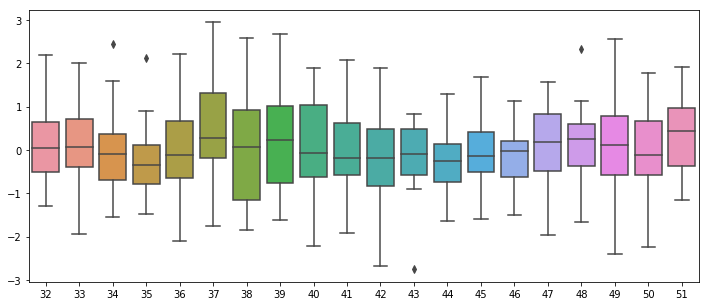

In [47]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

n = 480
ts = pd.Series(np.random.randn(n), index=pd.date_range(start="2014-02-01", periods=n, freq="H"))


fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(ts.index.dayofyear, ts, ax=ax)

In [7]:
ts.index

DatetimeIndex(['2014-02-01 00:00:00', '2014-02-01 01:00:00',
               '2014-02-01 02:00:00', '2014-02-01 03:00:00',
               '2014-02-01 04:00:00', '2014-02-01 05:00:00',
               '2014-02-01 06:00:00', '2014-02-01 07:00:00',
               '2014-02-01 08:00:00', '2014-02-01 09:00:00',
               ...
               '2014-02-20 14:00:00', '2014-02-20 15:00:00',
               '2014-02-20 16:00:00', '2014-02-20 17:00:00',
               '2014-02-20 18:00:00', '2014-02-20 19:00:00',
               '2014-02-20 20:00:00', '2014-02-20 21:00:00',
               '2014-02-20 22:00:00', '2014-02-20 23:00:00'],
              dtype='datetime64[ns]', length=480, freq='H')

In [12]:
ts.to_frame()

,0
2014-02-01 00:00:00,-0.892443
2014-02-01 01:00:00,0.193543
2014-02-01 02:00:00,2.248544
2014-02-01 03:00:00,0.836747
2014-02-01 04:00:00,-0.436948
...,...
2014-02-20 19:00:00,-0.154363
2014-02-20 20:00:00,0.020673
2014-02-20 21:00:00,-1.211424
2014-02-20 22:00:00,-0.248804


In [10]:
def _convert2date(y, t):
        return datetime.strptime(f'{y} {t} 1', '%Y %m %d')  # %G, %V, %u are ISO equivalents of %Y, %W, %w

In [11]:
ts.apply(lambda row: _convert2date(row.year, row.period), axis=1)

TypeError: <lambda>() got an unexpected keyword argument 'axis'